# Libraries

In [1]:
!pip -q install /kaggle/input/colombian-frenchteam-problematicinternetusage/pytorch_tabnet-4.1.0-py3-none-any.whl

In [2]:
from pytorch_tabnet.tab_model import TabNetRegressor
import torch

In [3]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import optuna
from sklearn.metrics import cohen_kappa_score, make_scorer, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import xgboost as xgb

In [4]:
import gc
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.offline

from colorama import Fore, Style, init
from pprint import pprint

# 🚫 Suppressing warnings 🚫
import warnings
warnings.filterwarnings('ignore')

In [5]:
SEED = 42
n_splits = 5

# Load data

In [6]:
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
len(test)

20

In [7]:
test.head(5)

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,32.6909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,3.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,27.0552,NaN,NaN,Fall,2.340,Fall,46.0,64.0,Summer,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,NaN,NaN,NaN,Summer,2.170,Fall,38.0,54.0,Summer,2.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,45.9966,NaN,NaN,Winter,2.451,Summer,31.0,45.0,Winter,0.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,Summer,1.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df = pd.read_csv('/kaggle/input/colombian-frenchteam-problematicinternetusage/Dataset_problematic_internet_usage.csv')
len(df)

3960

In [9]:
df.head(5)

,Unnamed: 0,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,...,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii,Has_actigraphy_data,Train_Test_Label
0,0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,...,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0,No,isnotintrainset
1,1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,...,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0,No,isnotintrainset
2,2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,...,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0,No,isnotintrainset
3,3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,...,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0,Yes,train
4,4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,isnotintrainset


In [10]:
sii_counts = df['sii'].value_counts(dropna=False)
sii_percentages = (sii_counts / sii_counts.sum()) * 100
sii_summary = pd.DataFrame({'Count': sii_counts,'Percentage': sii_percentages})

print(sii_summary)

     Count  Percentage
sii                   
0.0   1594   40.252525
NaN   1224   30.909091
1.0    730   18.434343
2.0    378    9.545455
3.0     34    0.858586


# Processing the data

In [11]:
featuresCols = ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season',
                'PAQ_C-PAQ_C_Total', 'SDS-Season', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
                'PreInt_EduHx-computerinternet_hoursday', 'sii']

In [12]:
df = df[featuresCols]
df = df.dropna(subset='sii')
len(df)

2736

In [13]:
df_unchanged = df.copy()

In [14]:
sii_counts = df['sii'].value_counts(dropna=False)
sii_percentages = (sii_counts / sii_counts.sum()) * 100
sii_summary = pd.DataFrame({'Count': sii_counts,'Percentage': sii_percentages})

print(sii_summary)

     Count  Percentage
sii                   
0.0   1594   58.260234
1.0    730   26.681287
2.0    378   13.815789
3.0     34    1.242690


In [15]:
def update(df):
    for c in cat_c: 
        df[c] = df[c].fillna('Missing')
        df[c] = df[c].astype('category')
    return df

In [16]:
cat_c = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season', 
          'FGC-Season', 'BIA-Season', 'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']

df = update(df)

In [17]:
def create_mapping(column, dataset):
    unique_values = dataset[column].unique()
    return {value: idx for idx, value in enumerate(unique_values)}

In [18]:
for col in cat_c:
    mapping_df = create_mapping(col, df)
    df[col] = df[col].replace(mapping_df).astype(int)

print(f'df Shape : {df.shape}')

df Shape : (2736, 59)


In [19]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_columns] = imputer.fit_transform(df[numeric_columns])

In [20]:
df.head()

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,...,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,0.0,5.0,0.0,0.0,51.000000,0.0,16.877316,46.0,50.8,26.625259,...,0.0,2.185758,0.0,2.590608,0.0,40.977839,57.647525,0.0,3.0,2.0
1,1.0,9.0,0.0,1.0,65.159266,0.0,14.035590,48.0,46.0,22.000000,...,0.0,2.185758,1.0,2.340000,1.0,46.000000,64.000000,1.0,0.0,0.0
2,1.0,10.0,1.0,2.0,71.000000,0.0,16.648696,56.5,75.6,26.625259,...,0.0,2.185758,2.0,2.170000,1.0,38.000000,54.000000,1.0,2.0,0.0
3,2.0,9.0,0.0,2.0,71.000000,1.0,18.292347,56.0,81.6,26.625259,...,0.0,2.185758,3.0,2.451000,2.0,31.000000,45.000000,2.0,0.0,1.0
5,3.0,13.0,1.0,0.0,50.000000,1.0,22.279952,59.5,112.2,26.625259,...,0.0,2.185758,4.0,4.110000,2.0,40.000000,56.000000,3.0,0.0,1.0


In [21]:
df_unchanged.head()

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,...,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,3.0,2.0
1,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,22.0,...,NaN,NaN,Fall,2.340,Fall,46.0,64.0,Summer,0.0,0.0
2,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,NaN,...,NaN,NaN,Summer,2.170,Fall,38.0,54.0,Summer,2.0,0.0
3,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,NaN,...,NaN,NaN,Winter,2.451,Summer,31.0,45.0,Winter,0.0,1.0
5,Spring,13,1,Winter,50.0,Summer,22.279952,59.5,112.2,NaN,...,NaN,NaN,Spring,4.110,Summer,40.0,56.0,Spring,0.0,1.0


# Random assignment to the classes

Mean of Quadratic Cohen's Kappa Score (Majority Class Prediction): 0.0
Mean of Quadratic Cohen's Kappa Score (Random Class Assignment - Uniform): -0.0010039568974111513


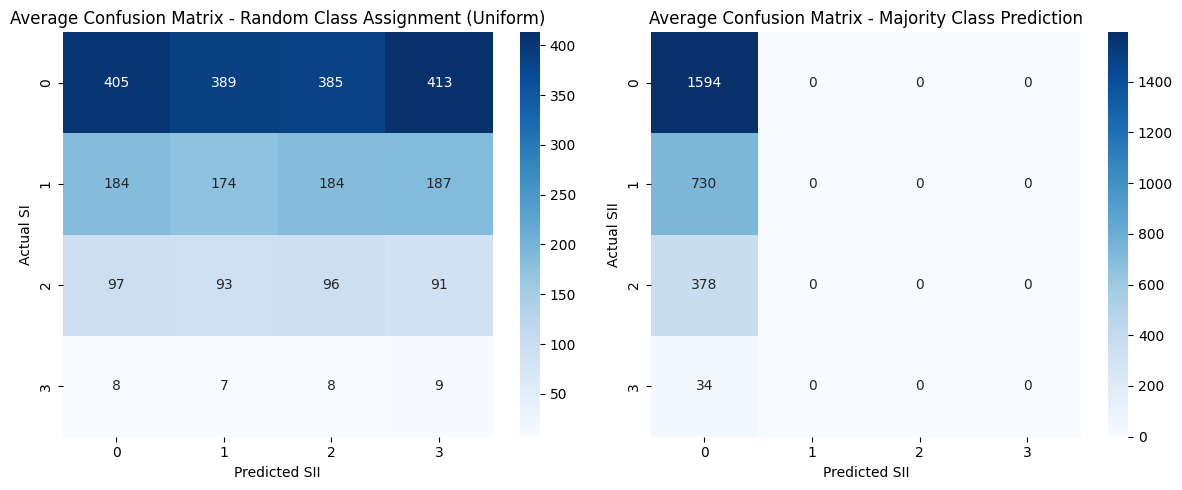

In [59]:

# 1. Get the distribution of the target variable 'sii'
from sklearn.metrics import cohen_kappa_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Get the distribution of the target variable 'sii'
distribution = {
    0: 0.58260234,  # 58.26%
    1: 0.26681287,  # 26.68%
    2: 0.13815789,  # 13.82%
    3: 0.01242690   # 1.24%
}

# 2. Define the number of samples
num_samples = len(df)  # Total number of samples

# Store the Kappa scores for different approaches
kappa_scores_majority = []
kappa_scores_random_uniform = []

# Store confusion matrices
confusion_majority_list = []
confusion_random_uniform_list = []

# 3. Run each naive approach 5 times
for _ in range(5):
    
    # Naive Approach 1: Majority Class Prediction
    majority_class = df['sii'].mode()[0]  # Get the most frequent class
    majority_predictions = np.full(num_samples, majority_class)  # Predict the majority class for all samples
    actual_values = df['sii'].values
    kappa_majority = cohen_kappa_score(actual_values, majority_predictions, weights='quadratic')
    kappa_scores_majority.append(kappa_majority)
    
    # Confusion Matrix for Majority Class Prediction
    cm_majority = confusion_matrix(actual_values, majority_predictions)
    confusion_majority_list.append(cm_majority)
    
    # Naive Approach 2: Random Class Assignment (uniform distribution)
    random_predictions_uniform = np.random.choice([0, 1, 2, 3], size=num_samples, p=[0.25, 0.25, 0.25, 0.25])
    kappa_random_uniform = cohen_kappa_score(actual_values, random_predictions_uniform, weights='quadratic')
    kappa_scores_random_uniform.append(kappa_random_uniform)

    # Confusion Matrix for Random Class Assignment (uniform)
    cm_random_uniform = confusion_matrix(actual_values, random_predictions_uniform)
    confusion_random_uniform_list.append(cm_random_uniform)

# 4. Calculate the mean of the Kappa scores for each approach
mean_kappa_majority = np.mean(kappa_scores_majority)
mean_kappa_random_uniform = np.mean(kappa_scores_random_uniform)

print(f"Mean of Quadratic Cohen's Kappa Score (Majority Class Prediction): {mean_kappa_majority}")
print(f"Mean of Quadratic Cohen's Kappa Score (Random Class Assignment - Uniform): {mean_kappa_random_uniform}")

# 5. Compute and plot the average confusion matrices for each approach

# Average confusion matrix for Majority Class Prediction
avg_cm_majority = np.mean(confusion_majority_list, axis=0).astype(int)
# Average confusion matrix for Random Class Assignment (Uniform)
avg_cm_random_uniform = np.mean(confusion_random_uniform_list, axis=0).astype(int)

# Plotting the confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Confusion matrix for Majority Class Prediction
sns.heatmap(avg_cm_majority, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3], ax=axes[1])
axes[1].set_title("Average Confusion Matrix - Majority Class Prediction")
axes[1].set_xlabel("Predicted SII")
axes[1].set_ylabel("Actual SII")

# Confusion matrix for Random Class Assignment (Uniform)
sns.heatmap(avg_cm_random_uniform, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3], ax=axes[0])
axes[0].set_title("Average Confusion Matrix - Random Class Assignment (Uniform)")
axes[0].set_xlabel("Predicted SII")
axes[0].set_ylabel("Actual SI")

plt.tight_layout()
plt.show()

In [63]:
cm_random_uniform

array([[398, 379, 381, 436],
       [179, 170, 195, 186],
       [ 99,  99,  91,  89],
       [  6,   7,  10,  11]])

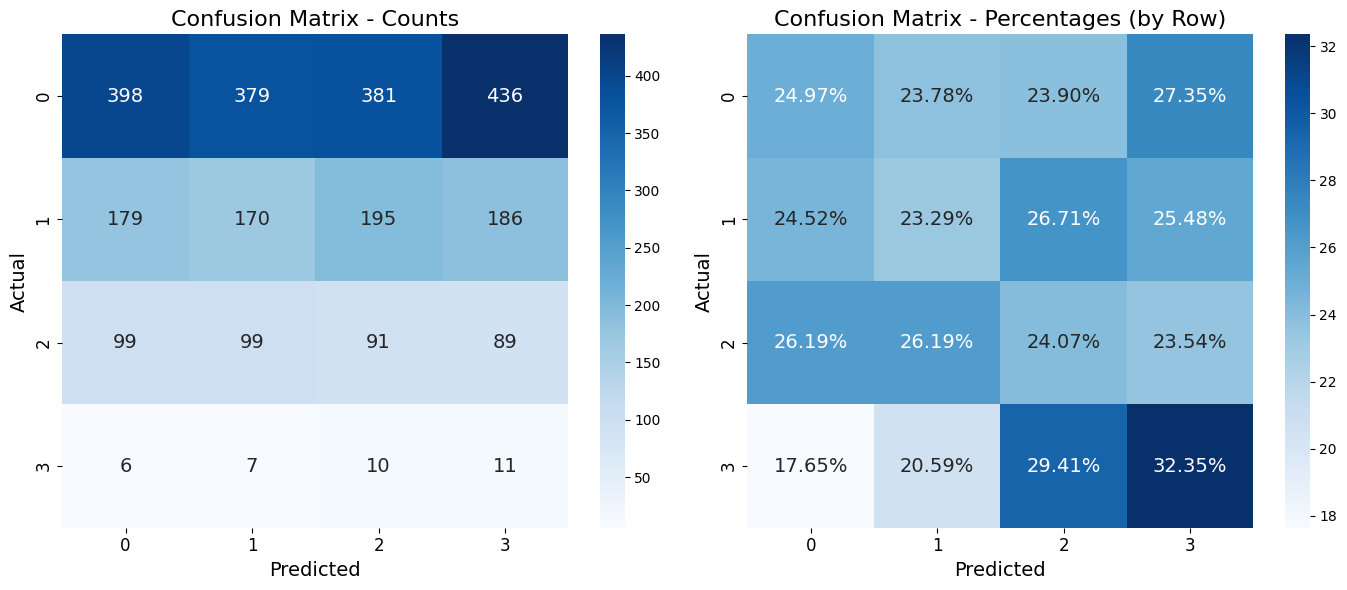

In [66]:
total_confusion_matrix = cm_random_uniform

# Calculate the percentage confusion matrix by row
row_sums = np.sum(total_confusion_matrix, axis=1, keepdims=True)  # Sum of each row
percentage_confusion_matrix_by_row = total_confusion_matrix / row_sums * 100  # Normalize by row

# Manually format the percentages by adding '%' to each label
formatted_percentage_matrix = np.array([['{:.2f}%'.format(val) for val in row] for row in percentage_confusion_matrix_by_row])

# Create a figure with two subplots: one for the counts and one for percentages
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot the confusion matrix with counts
sns.heatmap(total_confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3], ax=axes[0], annot_kws={"size": 14})
axes[0].set_title("Confusion Matrix - Counts", fontsize=16)
axes[0].set_xlabel("Predicted", fontsize=14)
axes[0].set_ylabel("Actual", fontsize=14)

# Increase font size for ticks
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)

# Plot the confusion matrix with formatted percentages by row
sns.heatmap(percentage_confusion_matrix_by_row, annot=formatted_percentage_matrix, fmt="s", cmap="Blues", xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3], ax=axes[1], annot_kws={"size": 14})
axes[1].set_title("Confusion Matrix - Percentages (by Row)", fontsize=16)
axes[1].set_xlabel("Predicted", fontsize=14)
axes[1].set_ylabel("Actual", fontsize=14)

# Increase font size for ticks
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelsize=12)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# Modelling of the LightGBM

In [36]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import optuna
from sklearn.metrics import cohen_kappa_score, make_scorer, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [37]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
import lightgbm as lgb
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [38]:
# Custom Kappa scorer
KAPPA_SCORER = make_scorer(
    cohen_kappa_score, 
    greater_is_better=True, 
    weights='quadratic'
)

# Custom LGBM Regressor with threshold optimization
class CustomLGBMRegressor(lgb.LGBMRegressor):
    '''
    Custom LightGBM Regressor
    
    It optimizes threshold values during fitting.
    Main goal is preventing overfit on validation data.
    '''
    def fit(self, X, y, **kwargs):
        super().fit(X, y, **kwargs)
        y_pred = super().predict(X, **kwargs)
        
        self.optimizer = minimize(
            eval_preds, 
            x0=[0.5, 1.5, 2.5], 
            args=(y, y_pred), 
            method='Nelder-Mead',
        )
        
    def predict(self, X, **kwargs):
        y_pred = super().predict(X, **kwargs)
        y_pred = threshold_Rounder(y_pred, self.optimizer.x)
        return y_pred

In [39]:
# Helper functions
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

def eval_preds(thresholds, y_true, y_pred):
    y_pred = threshold_Rounder(y_pred, thresholds)
    score = cohen_kappa_score(y_true, y_pred, weights='quadratic')
    return -score

In [40]:
def lgb_objective(trial):
    params = {
        'objective':         'l2',
        'verbosity':         -1,
        'n_iter':            200,
        'random_state':      SEED,
        'boosting_type':     'gbdt',
        'lambda_l1':         trial.suggest_float('lambda_l1', 1e-3, 10.0, log=True),
        'lambda_l2':         trial.suggest_float('lambda_l2', 1e-3, 10.0, log=True),
        'learning_rate':     trial.suggest_float('learning_rate', 1e-2, 1e-1, log=True),
        'max_depth':         trial.suggest_int('max_depth', 4, 8),
        'num_leaves':        trial.suggest_int('num_leaves', 16, 256),
        'colsample_bytree':  trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'colsample_bynode':  trial.suggest_float('colsample_bynode', 0.4, 1.0),
        'bagging_fraction':  trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq':      trial.suggest_int('bagging_freq', 1, 7),
        'min_data_in_leaf':  trial.suggest_int('min_data_in_leaf', 5, 100),
    }
    
    X = df.drop(['sii'], axis=1)
    y = df['sii']
    cv = StratifiedKFold(5, shuffle=True, random_state=SEED)
    estimator = CustomLGBMRegressor(**params)

    val_scores = cross_val_score(
        estimator=estimator, 
        X=X, y=y, 
        cv=cv, 
        scoring=KAPPA_SCORER,
    )

    return np.mean(val_scores)

In [41]:
# Create a study for each model and optimize
def optimize_model(objective, study_name):
    study = optuna.create_study(direction='maximize', study_name=study_name)
    study.optimize(objective, n_trials=30, show_progress_bar=True)
    return study.best_trial.params


In [42]:
# Optimizing for each model
best_params_lgb = optimize_model(lgb_objective, 'LGBM_Regressor')

# Print the best parameters for each model
print("Best parameters for LGBM:", best_params_lgb)

[I 2024-12-04 00:35:59,595] A new study created in memory with name: LGBM_Regressor


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2024-12-04 00:36:02,594] Trial 0 finished with value: 0.43591643946304315 and parameters: {'lambda_l1': 0.0013739540715125285, 'lambda_l2': 0.008529616088173958, 'learning_rate': 0.05466198188486095, 'max_depth': 8, 'num_leaves': 187, 'colsample_bytree': 0.4304552208105552, 'colsample_bynode': 0.5528680085604533, 'bagging_fraction': 0.7769169141585444, 'bagging_freq': 2, 'min_data_in_leaf': 46}. Best is trial 0 with value: 0.43591643946304315.
[I 2024-12-04 00:36:05,277] Trial 1 finished with value: 0.4613797919966706 and parameters: {'lambda_l1': 0.010229846221253723, 'lambda_l2': 0.004658743412114673, 'learning_rate': 0.03705627887974881, 'max_depth': 6, 'num_leaves': 117, 'colsample_bytree': 0.6371605814596447, 'colsample_bynode': 0.7029823694300081, 'bagging_fraction': 0.6318772123427072, 'bagging_freq': 4, 'min_data_in_leaf': 41}. Best is trial 1 with value: 0.4613797919966706.
[I 2024-12-04 00:36:07,683] Trial 2 finished with value: 0.4262508805892793 and parameters: {'lambda_

In [45]:
params_lgb = {
    'objective': 'l2',
    'verbosity': -1,
    'n_iter': 200,
    'random_state': SEED,
    'lambda_l1': 8.906831645766042,
     'lambda_l2': 0.004591584170840488,
     'learning_rate': 0.04874811806004515,
     'max_depth': 6,
     'num_leaves': 82,
     'colsample_bytree': 0.6403876590762936,
     'colsample_bynode': 0.49845692241164663,
     'bagging_fraction': 0.55635165528929,
     'bagging_freq': 1,
     'min_data_in_leaf': 70,
}

params_lgb.update(best_params_lgb)

In [46]:
X = df.drop(['sii'], axis=1)
y = df['sii']
cv = StratifiedKFold(5, shuffle=True, random_state=SEED)

model_lgb = CustomLGBMRegressor(**params_lgb)

In [49]:
len(X)

2736

Quadratic Cohen's Kappa Score (LGBM model): 0.46657304059743854


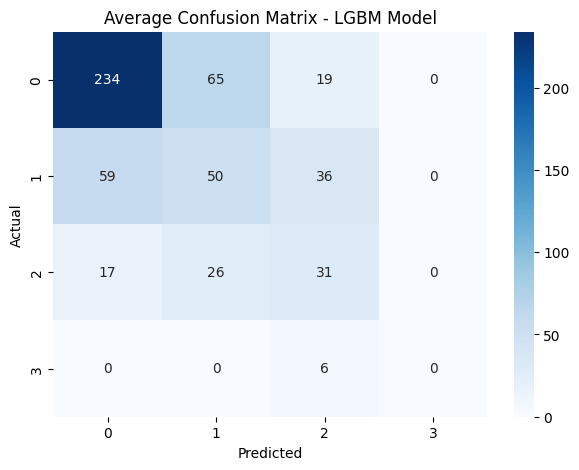

In [47]:
#Lists to store confusion matrices and predictions for each fold
confusion_matrices = []

# To store predictions and true values for plotting
all_preds = []
all_true = []

# Cross-validation loop
for train_index, test_index in cv.split(X, y):
    # Split data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit the model on the training data
    model_lgb.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model_lgb.predict(X_test)
    
    # You may need to round or map the predictions to the nearest class (if it's a regression model)
    # Assuming your model predicts continuous values and you need to map them to classes:
    y_pred_class = np.round(y_pred).astype(int)  # Round to nearest integer for classification
    
    # Ensure predictions are within the valid class range (0, 1, 2, 3)
    y_pred_class = np.clip(y_pred_class, 0, 3)
    
    # Calculate the confusion matrix for this fold
    cm = confusion_matrix(y_test, y_pred_class)
    confusion_matrices.append(cm)
    
    # Append the predictions and true values for later analysis
    all_preds.extend(y_pred_class)
    all_true.extend(y_test)

# Calculate the average confusion matrix
avg_confusion_matrix = np.mean(confusion_matrices, axis=0).astype(int)
total_confusion_matrix = np.sum(confusion_matrices, axis=0).astype(int)

# Calculate the overall Quadratic Cohen's Kappa score
kappa_score = cohen_kappa_score(all_true, all_preds, weights='quadratic')
print(f"Quadratic Cohen's Kappa Score (LGBM model): {kappa_score}")

# Plot the average confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(avg_confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.title("Average Confusion Matrix - LGBM Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [68]:
total_confusion_matrix = np.sum(confusion_matrices, axis=0).astype(int)

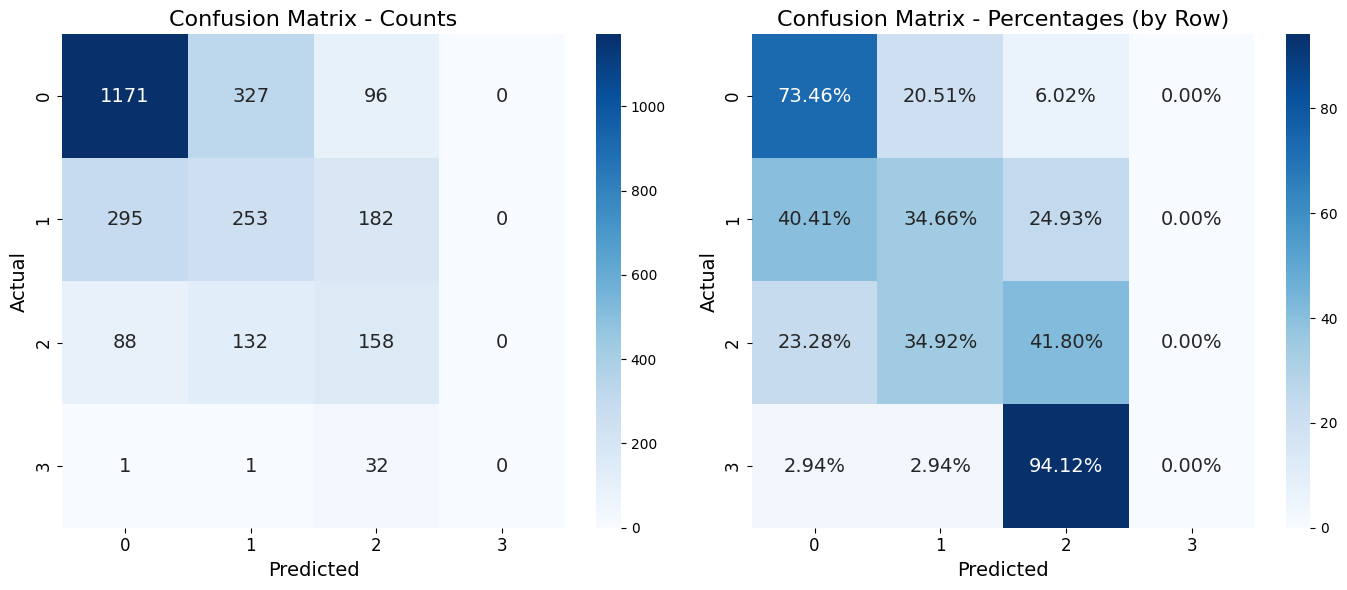

In [69]:
# Calculate the percentage confusion matrix by row
row_sums = np.sum(total_confusion_matrix, axis=1, keepdims=True)  # Sum of each row
percentage_confusion_matrix_by_row = total_confusion_matrix / row_sums * 100  # Normalize by row

# Manually format the percentages by adding '%' to each label
formatted_percentage_matrix = np.array([['{:.2f}%'.format(val) for val in row] for row in percentage_confusion_matrix_by_row])

# Create a figure with two subplots: one for the counts and one for percentages
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot the confusion matrix with counts
sns.heatmap(total_confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3], ax=axes[0], annot_kws={"size": 14})
axes[0].set_title("Confusion Matrix - Counts", fontsize=16)
axes[0].set_xlabel("Predicted", fontsize=14)
axes[0].set_ylabel("Actual", fontsize=14)

# Increase font size for ticks
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)

# Plot the confusion matrix with formatted percentages by row
sns.heatmap(percentage_confusion_matrix_by_row, annot=formatted_percentage_matrix, fmt="s", cmap="Blues", xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3], ax=axes[1], annot_kws={"size": 14})
axes[1].set_title("Confusion Matrix - Percentages (by Row)", fontsize=16)
axes[1].set_xlabel("Predicted", fontsize=14)
axes[1].set_ylabel("Actual", fontsize=14)

# Increase font size for ticks
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelsize=12)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# Modelling 

In [104]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import optuna
from sklearn.metrics import cohen_kappa_score, make_scorer, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [105]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
import lightgbm as lgb
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [106]:
# Custom Kappa scorer
KAPPA_SCORER = make_scorer(
    cohen_kappa_score, 
    greater_is_better=True, 
    weights='quadratic'
)

# Custom LGBM Regressor with threshold optimization
class CustomLGBMRegressor(lgb.LGBMRegressor):
    '''
    Custom LightGBM Regressor
    
    It optimizes threshold values during fitting.
    Main goal is preventing overfit on validation data.
    '''
    def fit(self, X, y, **kwargs):
        super().fit(X, y, **kwargs)
        y_pred = super().predict(X, **kwargs)
        
        self.optimizer = minimize(
            eval_preds, 
            x0=[0.5, 1.5, 2.5], 
            args=(y, y_pred), 
            method='Nelder-Mead',
        )
        
    def predict(self, X, **kwargs):
        y_pred = super().predict(X, **kwargs)
        y_pred = threshold_Rounder(y_pred, self.optimizer.x)
        return y_pred

class CustomXGBRegressor(XGBRegressor):
    def fit(self, X, y, **kwargs):
        super().fit(X, y, **kwargs)
        y_pred = super().predict(X, **kwargs)
        self.optimizer = minimize(
            eval_preds, 
            x0=[0.5, 1.5, 2.5], 
            args=(y, y_pred), 
            method='Nelder-Mead',
        )
        
    def predict(self, X, **kwargs):
        y_pred = super().predict(X, **kwargs)
        y_pred = threshold_Rounder(y_pred, self.optimizer.x)
        return y_pred

class CustomRFRegressor(RandomForestRegressor):
    def fit(self, X, y, **kwargs):
        super().fit(X, y, **kwargs)
        y_pred = super().predict(X, **kwargs)
        self.optimizer = minimize(
            eval_preds, 
            x0=[0.5, 1.5, 2.5], 
            args=(y, y_pred), 
            method='Nelder-Mead',
        )
        
    def predict(self, X, **kwargs):
        y_pred = super().predict(X, **kwargs)
        y_pred = threshold_Rounder(y_pred, self.optimizer.x)
        return y_pred

class CustomMLPRegressor(MLPRegressor):
    def fit(self, X, y, **kwargs):
        super().fit(X, y, **kwargs)
        y_pred = super().predict(X, **kwargs)
        self.optimizer = minimize(
            eval_preds, 
            x0=[0.5, 1.5, 2.5], 
            args=(y, y_pred), 
            method='Nelder-Mead',
        )
        
    def predict(self, X, **kwargs):
        y_pred = super().predict(X, **kwargs)
        y_pred = threshold_Rounder(y_pred, self.optimizer.x)
        return y_pred
    
class CustomTabNetRegressor(TabNetRegressor):
    
    def __init__(self, optimizer_params=None, **kwargs):
        """
        Initialize the TabNetRegressor with optimizer parameters.
        optimizer_params should include 'lr', 'weight_decay', etc.
        """
        if optimizer_params is None:
            optimizer_params = dict(lr=2e-2, weight_decay=1e-5)
        
        # Pass optimizer_params to the TabNetRegressor constructor
        super().__init__(optimizer_params=optimizer_params, **kwargs)

    def fit(self, X_train, y_train, max_epochs=100, batch_size=512, virtual_batch_size=64, **kwargs):
        """
        Fit the TabNet model and optimize thresholds using minimize.
        """
        # Fit the model using the inherited fit method from TabNet
        super().fit(
            X_train, y_train,
            max_epochs=max_epochs,
            batch_size=batch_size,
            virtual_batch_size=virtual_batch_size,
            **kwargs  # Additional parameters passed here (e.g., callbacks)
        )
        
        # Predict on the training data
        y_pred = super().predict(X_train)
        
        # Optimize the threshold using a separate optimization function
        self.optimizer = minimize(
            eval_preds, 
            x0=[0.5, 1.5, 2.5],  # Initial thresholds
            args=(y_train, y_pred),  # Actual and predicted labels
            method='Nelder-Mead',
        )
        
    def predict(self, X, **kwargs):
        y_pred = super().predict(X)
        y_pred = threshold_Rounder(y_pred, self.optimizer.x)
        return y_pred

In [107]:
# Helper functions
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

def eval_preds(thresholds, y_true, y_pred):
    y_pred = threshold_Rounder(y_pred, thresholds)
    score = cohen_kappa_score(y_true, y_pred, weights='quadratic')
    return -score

In [108]:
def lgb_objective(trial):
    params = {
        'objective':         'l2',
        'verbosity':         -1,
        'n_iter':            200,
        'random_state':      SEED,
        'boosting_type':     'gbdt',
        'lambda_l1':         trial.suggest_float('lambda_l1', 1e-3, 10.0, log=True),
        'lambda_l2':         trial.suggest_float('lambda_l2', 1e-3, 10.0, log=True),
        'learning_rate':     trial.suggest_float('learning_rate', 1e-2, 1e-1, log=True),
        'max_depth':         trial.suggest_int('max_depth', 4, 8),
        'num_leaves':        trial.suggest_int('num_leaves', 16, 256),
        'colsample_bytree':  trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'colsample_bynode':  trial.suggest_float('colsample_bynode', 0.4, 1.0),
        'bagging_fraction':  trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq':      trial.suggest_int('bagging_freq', 1, 7),
        'min_data_in_leaf':  trial.suggest_int('min_data_in_leaf', 5, 100),
    }
    
    X = df.drop(['sii'], axis=1)
    y = df['sii']
    cv = StratifiedKFold(5, shuffle=True, random_state=SEED)
    estimator = CustomLGBMRegressor(**params)

    val_scores = cross_val_score(
        estimator=estimator, 
        X=X, y=y, 
        cv=cv, 
        scoring=KAPPA_SCORER,
    )

    return np.mean(val_scores)

# Define objective for XGB
def xgb_objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'verbosity': 0,
        'n_estimators': 200,
        'random_state': SEED,
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 1e-2, 1e-1, log=True),
        'max_depth': trial.suggest_int('max_depth', 4, 8),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.4, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    }

    X = df.drop(['sii'], axis=1)
    y = df['sii']
    cv = StratifiedKFold(5, shuffle=True, random_state=SEED)
    estimator = CustomXGBRegressor(**params)

    val_scores = cross_val_score(
        estimator=estimator, 
        X=X, y=y, 
        cv=cv, 
        scoring=KAPPA_SCORER,
    )

    return np.mean(val_scores)

# Define objective for Random Forest
def rf_objective(trial):
    params = {
        'n_estimators': 200,
        'random_state': SEED,
        'max_depth': trial.suggest_int('max_depth', 4, 8),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_float('max_features', 0.5, 1.0),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
    }

    X = df.drop(['sii'], axis=1)
    y = df['sii']
    cv = StratifiedKFold(5, shuffle=True, random_state=SEED)
    estimator = CustomRFRegressor(**params)

    val_scores = cross_val_score(
        estimator=estimator, 
        X=X, y=y, 
        cv=cv, 
        scoring=KAPPA_SCORER,
    )

    return np.mean(val_scores)

# Define objective for MLP
def mlp_objective(trial):
    params = {
        'hidden_layer_sizes': trial.suggest_categorical('hidden_layer_sizes', [(50,), (100,), (200,), (100, 50)]),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'logistic']),
        'solver': trial.suggest_categorical('solver', ['adam', 'sgd']),
        'alpha': trial.suggest_float('alpha', 1e-5, 1e-1, log=True),
        'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'invscaling', 'adaptive']),
        'random_state': SEED,
        'max_iter': 200,
    }

    X = df.drop(['sii'], axis=1)
    y = df['sii']
    cv = StratifiedKFold(5, shuffle=True, random_state=SEED)
    estimator = CustomMLPRegressor(**params)

    val_scores = cross_val_score(
        estimator=estimator, 
        X=X, y=y, 
        cv=cv, 
        scoring=KAPPA_SCORER,
    )

    return np.mean(val_scores)

def tabnet_objective(trial):
    """
    Objective function for TabNet hyperparameter tuning using Optuna.
    """
    # Suggest hyperparameters for TabNet
    params = {
        'n_d': trial.suggest_int('n_d', 32, 128),  # Width of the decision prediction layer
        'n_a': trial.suggest_int('n_a', 32, 128),  # Width of the attention embedding for each step
        'n_steps': trial.suggest_int('n_steps', 3, 10),  # Number of steps in the architecture
        'gamma': trial.suggest_float('gamma', 1.0, 3.0),  # Coefficient for feature selection regularization
        'n_independent': trial.suggest_int('n_independent', 1, 4),  # Number of independent GLU layers
        'n_shared': trial.suggest_int('n_shared', 1, 4),  # Number of shared GLU layers
        'lambda_sparse': trial.suggest_float('lambda_sparse', 1e-5, 1e-3, log=True),  # Sparsity regularization
        'mask_type': 'entmax',  # Type of attention mask
        'scheduler_fn': torch.optim.lr_scheduler.ReduceLROnPlateau,  # Learning rate scheduler
    }

    # Cross-validation setup
    X = df.drop(['sii'], axis=1)
    y = df['sii']

    # Convert X and y to NumPy arrays
    X = X.values  # Convert to NumPy array
    y = y.values  # Convert to NumPy array

    # Reshape y to be 2D for regression (n_samples, 1)
    y = y.reshape(-1, 1)

    # Create StratifiedKFold cross-validation iterator
    cv = StratifiedKFold(5, shuffle=True, random_state=SEED)

    # Create model with suggested hyperparameters
    estimator = CustomTabNetRegressor(**params)

    # Pass optimizer parameters separately
    optimizer_params = {
        'lr': trial.suggest_float('lr', 1e-3, 1e-1, log=True),  # Learning rate
        'weight_decay': trial.suggest_float('weight_decay', 1e-6, 1e-4, log=True)  # Weight decay for regularization
    }

    # Update the model with optimizer parameters
    estimator.optimizer_params.update(optimizer_params)

    # Fit the model using cross-validation
    val_scores = cross_val_score(
        estimator=estimator, 
        X=X, 
        y=y, 
        cv=cv, 
        scoring=KAPPA_SCORER,
        fit_params={'max_epochs': 100, 'batch_size': 512, 'virtual_batch_size': 64}  # Pass fit params
    )

    # Return the mean score across all folds
    return np.mean(val_scores)

In [109]:
# Create a study for each model and optimize
def optimize_model(objective, study_name):
    study = optuna.create_study(direction='maximize', study_name=study_name)
    study.optimize(objective, n_trials=30, show_progress_bar=True)
    return study.best_trial.params


In [110]:
# Optimizing for each model
best_params_lgb = optimize_model(lgb_objective, 'LGBM_Regressor')
best_params_xgb = optimize_model(xgb_objective, 'XGB_Regressor')
best_params_rf = optimize_model(rf_objective, 'RF_Regressor')
best_params_mlp = optimize_model(mlp_objective, 'MLP_Regressor')
best_params_tabnet = optimize_model(tabnet_objective, 'TabNet_Regressor')

# Print the best parameters for each model
print("Best parameters for LGBM:", best_params_lgb)
print("Best parameters for XGB:", best_params_xgb)
print("Best parameters for RF:", best_params_rf)
print("Best parameters for MLP:", best_params_mlp)
print("Best parameters for tabnet:", best_params_tabnet)

[I 2024-11-16 17:12:58,394] A new study created in memory with name: LGBM_Regressor


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2024-11-16 17:13:01,340] Trial 0 finished with value: 0.441854935024746 and parameters: {'lambda_l1': 0.3310239835981334, 'lambda_l2': 0.0016288038323393765, 'learning_rate': 0.09821515153673938, 'max_depth': 4, 'num_leaves': 222, 'colsample_bytree': 0.7611314158235188, 'colsample_bynode': 0.7529369426323282, 'bagging_fraction': 0.42348550248001865, 'bagging_freq': 5, 'min_data_in_leaf': 74}. Best is trial 0 with value: 0.441854935024746.
[I 2024-11-16 17:13:04,752] Trial 1 finished with value: 0.4497379637245655 and parameters: {'lambda_l1': 1.198645791574789, 'lambda_l2': 0.0074924724299313995, 'learning_rate': 0.05445832482630105, 'max_depth': 8, 'num_leaves': 206, 'colsample_bytree': 0.5960598588583773, 'colsample_bynode': 0.4766798575997839, 'bagging_fraction': 0.8302476633328875, 'bagging_freq': 1, 'min_data_in_leaf': 89}. Best is trial 1 with value: 0.4497379637245655.
[I 2024-11-16 17:13:08,100] Trial 2 finished with value: 0.4304809709100098 and parameters: {'lambda_l1': 0.

[I 2024-11-16 17:14:39,141] A new study created in memory with name: XGB_Regressor


[I 2024-11-16 17:14:39,135] Trial 29 finished with value: 0.45482330550971 and parameters: {'lambda_l1': 0.007924454569383786, 'lambda_l2': 0.0010415854103504383, 'learning_rate': 0.03234505756181652, 'max_depth': 4, 'num_leaves': 234, 'colsample_bytree': 0.7853152034660538, 'colsample_bynode': 0.725168986505996, 'bagging_fraction': 0.44356572355622775, 'bagging_freq': 4, 'min_data_in_leaf': 58}. Best is trial 15 with value: 0.4687187354105551.


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2024-11-16 17:14:44,391] Trial 0 finished with value: 0.3614784543826826 and parameters: {'lambda': 0.24452925070902043, 'alpha': 0.034981461250510416, 'learning_rate': 0.08360545699629954, 'max_depth': 8, 'subsample': 0.5697725899572068, 'colsample_bytree': 0.8709046404033338, 'colsample_bylevel': 0.4157123892494154, 'min_child_weight': 4}. Best is trial 0 with value: 0.3614784543826826.
[I 2024-11-16 17:14:50,335] Trial 1 finished with value: 0.43341799070146064 and parameters: {'lambda': 0.016129701534779356, 'alpha': 0.09689818665411498, 'learning_rate': 0.010324787798624025, 'max_depth': 7, 'subsample': 0.7598297996781374, 'colsample_bytree': 0.5623506756955988, 'colsample_bylevel': 0.6240165497733672, 'min_child_weight': 4}. Best is trial 1 with value: 0.43341799070146064.
[I 2024-11-16 17:14:54,711] Trial 2 finished with value: 0.450482334691657 and parameters: {'lambda': 0.0015088715342812338, 'alpha': 4.17500983416994, 'learning_rate': 0.022953485785256765, 'max_depth': 4, 

[I 2024-11-16 17:16:54,240] A new study created in memory with name: RF_Regressor


[I 2024-11-16 17:16:54,235] Trial 29 finished with value: 0.40100159905309185 and parameters: {'lambda': 0.22835972899965157, 'alpha': 0.03715572498164378, 'learning_rate': 0.03380786431999611, 'max_depth': 8, 'subsample': 0.9590302165955789, 'colsample_bytree': 0.8785356633385963, 'colsample_bylevel': 0.992321237339262, 'min_child_weight': 8}. Best is trial 6 with value: 0.4608505570289525.


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2024-11-16 17:17:20,747] Trial 0 finished with value: 0.35383587649004966 and parameters: {'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 0.9933468926605769, 'bootstrap': False}. Best is trial 0 with value: 0.35383587649004966.
[I 2024-11-16 17:17:47,098] Trial 1 finished with value: 0.40512484889453465 and parameters: {'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 9, 'max_features': 0.8262747288530691, 'bootstrap': False}. Best is trial 1 with value: 0.40512484889453465.
[I 2024-11-16 17:18:09,013] Trial 2 finished with value: 0.41327029881256083 and parameters: {'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 9, 'max_features': 0.7889309972957748, 'bootstrap': False}. Best is trial 2 with value: 0.41327029881256083.
[I 2024-11-16 17:18:27,463] Trial 3 finished with value: 0.44008143969120866 and parameters: {'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': 0.6614104793570204, 'bootstrap': True}

[I 2024-11-16 17:25:16,849] A new study created in memory with name: MLP_Regressor


[I 2024-11-16 17:25:16,844] Trial 29 finished with value: 0.4414273949727166 and parameters: {'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 0.5459666606758016, 'bootstrap': False}. Best is trial 14 with value: 0.4549161248302491.


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2024-11-16 17:25:26,105] Trial 0 finished with value: 0.05631940783195888 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 4.0052666731036004e-05, 'learning_rate': 'invscaling'}. Best is trial 0 with value: 0.05631940783195888.
[I 2024-11-16 17:25:29,841] Trial 1 finished with value: 0.0 and parameters: {'hidden_layer_sizes': (50,), 'activation': 'logistic', 'solver': 'sgd', 'alpha': 0.0009336867851952742, 'learning_rate': 'constant'}. Best is trial 0 with value: 0.05631940783195888.
[I 2024-11-16 17:25:42,982] Trial 2 finished with value: 0.38921762303251217 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.003064051026306662, 'learning_rate': 'invscaling'}. Best is trial 2 with value: 0.38921762303251217.
[I 2024-11-16 17:25:52,352] Trial 3 finished with value: 0.05163790838507445 and parameters: {'hidden_layer_sizes': (50,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0878904

[I 2024-11-16 17:32:02,364] A new study created in memory with name: TabNet_Regressor


[I 2024-11-16 17:32:02,355] Trial 29 finished with value: 0.21637245263370372 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.00010321873045811439, 'learning_rate': 'constant'}. Best is trial 2 with value: 0.38921762303251217.


  0%|          | 0/30 [00:00<?, ?it/s]

epoch 0  | loss: 2.5574  |  0:00:00s
epoch 1  | loss: 0.82727 |  0:00:00s
epoch 2  | loss: 0.63518 |  0:00:00s
epoch 3  | loss: 0.59516 |  0:00:00s
epoch 4  | loss: 0.57915 |  0:00:01s
epoch 5  | loss: 0.56411 |  0:00:01s
epoch 6  | loss: 0.55293 |  0:00:01s
epoch 7  | loss: 0.54482 |  0:00:01s
epoch 8  | loss: 0.54354 |  0:00:02s
epoch 9  | loss: 0.5331  |  0:00:02s
epoch 10 | loss: 0.52009 |  0:00:02s
epoch 11 | loss: 0.50704 |  0:00:02s
epoch 12 | loss: 0.50695 |  0:00:03s
epoch 13 | loss: 0.50455 |  0:00:03s
epoch 14 | loss: 0.49291 |  0:00:03s
epoch 15 | loss: 0.50077 |  0:00:03s
epoch 16 | loss: 0.49885 |  0:00:04s
epoch 17 | loss: 0.49504 |  0:00:04s
epoch 18 | loss: 0.49437 |  0:00:04s
epoch 19 | loss: 0.48704 |  0:00:04s
epoch 20 | loss: 0.49394 |  0:00:04s
epoch 21 | loss: 0.49095 |  0:00:05s
epoch 22 | loss: 0.48434 |  0:00:05s
epoch 23 | loss: 0.47586 |  0:00:05s
epoch 24 | loss: 0.48277 |  0:00:05s
epoch 25 | loss: 0.48027 |  0:00:06s
epoch 26 | loss: 0.47229 |  0:00:06s
e

In [ ]:
# Print the best parameters for each model
print("Best parameters for LGBM:", best_params_lgb)
print("Best parameters for XGB:", best_params_xgb)
print("Best parameters for RF:", best_params_rf)
print("Best parameters for MLP:", best_params_mlp)
print("Best parameters for tabnet:", best_params_tabnet)

In [111]:
params_lgb = {
    'objective': 'l2',
    'verbosity': -1,
    'n_iter': 200,
    'random_state': SEED,
    'lambda_l1': 8.906831645766042,
     'lambda_l2': 0.004591584170840488,
     'learning_rate': 0.04874811806004515,
     'max_depth': 6,
     'num_leaves': 82,
     'colsample_bytree': 0.6403876590762936,
     'colsample_bynode': 0.49845692241164663,
     'bagging_fraction': 0.55635165528929,
     'bagging_freq': 1,
     'min_data_in_leaf': 70,
}

params_xgb = {
        'objective': 'reg:squarederror',
        'verbosity': 0,
        'n_estimators': 200,
        'random_state': SEED,
        'lambda': 1e-3,
        'alpha': 1e-3,
        'learning_rate': 1e-2,
        'max_depth': 4,
        'subsample': 0.5,
        'colsample_bytree': 0.4,
        'colsample_bylevel': 0.4,
        'min_child_weight': 1,
}

params_rf= {
        'n_estimators': 200,
        'random_state': SEED,
        'max_depth': 4,
        'min_samples_split': 2,
        'min_samples_leaf': 1,
        'max_features': 0.5,
        'bootstrap': True,
}

params_mlp = {
        'hidden_layer_sizes': (100, 50), 
        'activation': 'relu',
        'solver': 'adam',
        'alpha': 0.053958855282467966,
        'learning_rate': 'adaptive',
        'random_state': SEED,
        'max_iter': 200,
}

params_lgb.update(best_params_lgb)
params_xgb.update(best_params_xgb)
params_rf.update(best_params_rf)
params_mlp.update(best_params_mlp)

In [112]:
# Define optimizer params
optimizer_params_tabnet = {
    'lr': best_params_tabnet['lr'],
    'weight_decay': best_params_tabnet['weight_decay']
}

params_tabnet = {
    'n_d': best_params_tabnet['n_d'],
    'n_a': best_params_tabnet['n_a'],
    'n_steps': best_params_tabnet['n_steps'],
    'gamma': best_params_tabnet['gamma'],
    'n_independent': best_params_tabnet['n_independent'],
    'n_shared': best_params_tabnet['n_shared'],
    'lambda_sparse': best_params_tabnet['lambda_sparse'],
    'mask_type': 'entmax',  # Type of attention mask
    'optimizer_params': optimizer_params_tabnet,  # Include optimizer params
    'scheduler_fn': torch.optim.lr_scheduler.ReduceLROnPlateau,  # Learning rate scheduler
}

In [114]:
X = df.drop(['sii'], axis=1)
y = df['sii']
cv = StratifiedKFold(5, shuffle=True, random_state=SEED)

model_lgb = CustomLGBMRegressor(**params_lgb)
model_xgb = CustomXGBRegressor(**params_xgb)
model_rf = CustomRFRegressor(**params_rf)
model_mlp = CustomMLPRegressor(**params_mlp)

In [115]:
model_tabnet = CustomTabNetRegressor(**params_tabnet)

In [116]:
val_scores_lgb = cross_val_score(model_lgb, X, y, cv=cv, scoring=KAPPA_SCORER,)
val_scores_xgb = cross_val_score(model_xgb, X, y, cv=cv, scoring=KAPPA_SCORER,)
val_scores_rf = cross_val_score(model_rf, X, y, cv=cv, scoring=KAPPA_SCORER,)
val_scores_mlp = cross_val_score(model_mlp, X, y, cv=cv, scoring=KAPPA_SCORER,)
val_scores_tabnet = cross_val_score(model_tabnet, X.values, y.values.reshape(-1, 1), cv=cv, scoring=KAPPA_SCORER,)

kappa_scores = {
    'LGBM': np.mean(val_scores_lgb),
    'XGB': np.mean(val_scores_xgb),
    'RF': np.mean(val_scores_rf),
    'MLP': np.mean(val_scores_mlp),
    'TabNet': np.mean(val_scores_tabnet),
}

epoch 0  | loss: 4.03146 |  0:00:00s
epoch 1  | loss: 2.45625 |  0:00:00s
epoch 2  | loss: 1.44127 |  0:00:00s
epoch 3  | loss: 0.99064 |  0:00:00s
epoch 4  | loss: 0.88487 |  0:00:01s
epoch 5  | loss: 0.85287 |  0:00:01s
epoch 6  | loss: 0.71902 |  0:00:01s
epoch 7  | loss: 0.67806 |  0:00:01s
epoch 8  | loss: 0.64952 |  0:00:02s
epoch 9  | loss: 0.62397 |  0:00:02s
epoch 10 | loss: 0.62783 |  0:00:02s
epoch 11 | loss: 0.60819 |  0:00:02s
epoch 12 | loss: 0.59271 |  0:00:03s
epoch 13 | loss: 0.58631 |  0:00:03s
epoch 14 | loss: 0.56911 |  0:00:03s
epoch 15 | loss: 0.56904 |  0:00:03s
epoch 16 | loss: 0.55864 |  0:00:04s
epoch 17 | loss: 0.56704 |  0:00:04s
epoch 18 | loss: 0.55794 |  0:00:04s
epoch 19 | loss: 0.53454 |  0:00:04s
epoch 20 | loss: 0.54602 |  0:00:05s
epoch 21 | loss: 0.5425  |  0:00:05s
epoch 22 | loss: 0.54303 |  0:00:05s
epoch 23 | loss: 0.53037 |  0:00:05s
epoch 24 | loss: 0.5168  |  0:00:06s
epoch 25 | loss: 0.54104 |  0:00:06s
epoch 26 | loss: 0.52899 |  0:00:06s
e

In [117]:
# Print all Kappa scores at once
for model_name, kappa_score in kappa_scores.items():
    print(f'{model_name} Kappa score: {kappa_score:.4f}')

LGBM Kappa score: 0.4687
XGB Kappa score: 0.4609
RF Kappa score: 0.4549
MLP Kappa score: 0.3892
TabNet Kappa score: 0.4214


In [118]:
model_lgb.fit(X, y)
model_xgb.fit(X, y)
model_rf.fit(X, y)
model_mlp.fit(X, y)

In [119]:
model_tabnet.fit(X.values, y.values.reshape(-1, 1))

epoch 0  | loss: 9.0414  |  0:00:01s
epoch 1  | loss: 8.15387 |  0:00:02s
epoch 2  | loss: 6.65389 |  0:00:03s
epoch 3  | loss: 4.88597 |  0:00:04s
epoch 4  | loss: 3.55876 |  0:00:05s
epoch 5  | loss: 2.62336 |  0:00:06s
epoch 6  | loss: 1.8444  |  0:00:07s
epoch 7  | loss: 1.79036 |  0:00:08s
epoch 8  | loss: 1.44836 |  0:00:09s
epoch 9  | loss: 1.23063 |  0:00:10s
epoch 10 | loss: 1.0781  |  0:00:11s
epoch 11 | loss: 1.10629 |  0:00:12s
epoch 12 | loss: 1.14254 |  0:00:13s
epoch 13 | loss: 2.03139 |  0:00:14s
epoch 14 | loss: 6.0133  |  0:00:15s
epoch 15 | loss: 4.21541 |  0:00:16s
epoch 16 | loss: 4.01189 |  0:00:17s
epoch 17 | loss: 2.30908 |  0:00:18s
epoch 18 | loss: 1.15992 |  0:00:19s
epoch 19 | loss: 2.54319 |  0:00:20s
epoch 20 | loss: 1.72271 |  0:00:21s
epoch 21 | loss: 3.95167 |  0:00:22s
epoch 22 | loss: 1.04675 |  0:00:24s
epoch 23 | loss: 1.03773 |  0:00:25s
epoch 24 | loss: 1.26146 |  0:00:26s
epoch 25 | loss: 0.85442 |  0:00:27s
epoch 26 | loss: 0.71674 |  0:00:28s
e

In [120]:
# Check individual model predictions
y_pred_lgb = model_lgb.predict(X)
y_pred_xgb = model_xgb.predict(X)
y_pred_rf = model_rf.predict(X)
y_pred_mlp = model_mlp.predict(X)

# Print the first few predictions for each model to check for variance
print("LGBM predictions:", y_pred_lgb[:10])
print("XGB predictions:", y_pred_xgb[:10])
print("RF predictions:", y_pred_rf[:10])
print("MLP predictions:", y_pred_mlp[:10])

LGBM predictions: [0 0 0 0 0 1 1 1 0 0]
XGB predictions: [1 0 0 0 1 1 0 1 1 0]
RF predictions: [0 0 0 0 1 0 0 1 0 0]
MLP predictions: [0 0 0 0 0 0 0 1 1 0]


In [121]:
y_pred_tab = model_tabnet.predict(X.values).flatten()

# Print the first few predictions for each model to check for variance
print("Tabnet predictions:", y_pred_tab[:10])

Tabnet predictions: [1 0 1 0 0 0 0 1 2 0]


In [122]:
all_preds = np.array([y_pred_lgb, y_pred_xgb, y_pred_rf, y_pred_mlp, y_pred_tab])
voted_preds = np.apply_along_axis(lambda x: np.bincount(x.astype(int)).argmax(), axis=0, arr=all_preds)
kappa_score = cohen_kappa_score(y, voted_preds)
print(f'Majority Voting Kappa score: {kappa_score:.4f}')

Majority Voting Kappa score: 0.3850


In [123]:
all_preds = np.array([y_pred_lgb, y_pred_xgb, y_pred_rf])
voted_preds = np.apply_along_axis(lambda x: np.bincount(x.astype(int)).argmax(), axis=0, arr=all_preds)
kappa_score = cohen_kappa_score(y, voted_preds)
print(f'Majority Voting Kappa score: {kappa_score:.4f}')

Majority Voting Kappa score: 0.3850


In [124]:
all_preds = np.array([y_pred_lgb, y_pred_xgb, y_pred_rf,y_pred_tab])
voted_preds = np.apply_along_axis(lambda x: np.bincount(x.astype(int)).argmax(), axis=0, arr=all_preds)
kappa_score = cohen_kappa_score(y, voted_preds)
print(f'Majority Voting Kappa score: {kappa_score:.4f}')

Majority Voting Kappa score: 0.3872


# Seems the best model is the LGBM so far with a predicted score of 0.4719

In [158]:
model = model_lgb

# Submission 

In [163]:
test = update(test)

for col in cat_c:
    mapping_test = create_mapping(col, test)
    test[col] = test[col].replace(mapping_test).astype(int)

print(f'Test Shape : {test.shape}')

Test Shape : (20, 59)


In [164]:
numeric_columns = test.select_dtypes(include=['float64', 'int64']).columns
test[numeric_columns] = imputer.fit_transform(test[numeric_columns])

In [165]:
Submission = test[['id']]
test = test.drop('id', axis=1)
Submission['sii'] = model.predict(test)

In [166]:
Submission

,id,sii
0,00008ff9,0
1,000fd460,0
2,00105258,0
3,00115b9f,0
4,0016bb22,0
5,001f3379,1
6,0038ba98,1
7,0068a485,0
8,0069fbed,1
9,0083e397,0


In [167]:
Submission.to_csv('submission.csv', index=False)
print(Submission['sii'].value_counts())

sii
0    15
1     5
Name: count, dtype: int64
